In [44]:
from sklearn.datasets import make_blobs
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import animation as an
from typing import Tuple, Mapping
import random
from enum import Enum

In [115]:
class Function(Enum):#Enum для выбора функций 
  MATIAS = 1
  SPHERE = 2
class SGD_Modification(Enum):#Enum для выбора модификаций
  SIMPLE = 1 # без модификаций
  MOMENT = 2 # моментная
  ADAPTIVE = 3 # Adam
'''#############################################################################
Анимация работы SGD и его модификаций
'''#############################################################################
class AnimationSGD:
  def __init__(self, 
               sgd_simple: list, 
               sgd_moment:list,
               sgd_adaptive:list,
               f:Function = Function.SPHERE
               ):
    self.sgd_simple = sgd_simple[::10]
    self.sgd_moment = sgd_moment[:1000:]
    self.sgd_adaptive = sgd_adaptive[::10]
    self.f = self.Matias if f == Function.MATIAS else self.Sphere

  def Matias (self, x: np.array, y:np.array) -> np.float128 :
    return 0.26*(x*x + y*y) - 0.48*x*y
  def Sphere (self,x: np.ndarray, y:np.ndarray,
              r: np.ndarray = 0.8)-> np.float128:
    return -np.sqrt(-x**2 - y**2 + r**2) 

  def Start_Animation(self):
    x = np.linspace(-0.5, 0.5, 100) 
    y = np.linspace(-0.5, 0.5, 100) 
    X, Y = np.meshgrid(x, y)
    Z = self.f(X, Y)
    fig = plt.figure(figsize=(15,10))
    ax = fig.gca(projection='3d')
    ax.view_init(40, 15)
    ax.plot_wireframe(X, Y, Z, color ='blue', alpha = 0.1)
    ax.scatter(0, 0, -0.8, color='red',
               alpha = 0.5 , linewidths=10, label='Отпимум')

    points_simple, = ax.plot([], [], [], 
                             linestyle='dashed',
                             marker='<', markersize=15, color='green',
                             markeredgecolor='black',
                             label='SGD')
    points_moment, = ax.plot([], [], [],
                             linestyle='dashed',
                             marker='p', markersize=15, color='brown',
                             markeredgecolor='black',
                             label='SGD c моментной модификацией')
    points_adaptive, = ax.plot([], [], [],
                               linestyle='dashed',
                               marker='o', markersize=15, color='grey',
                               markeredgecolor='black',
                               label='SGD с адаптивной модификацией')
    ax.legend(fontsize=15, loc='lower left' )
    def init_func():
      points_simple.set_data_3d([], [], [])
      points_moment.set_data_3d([], [], [])
      points_adaptive.set_data_3d([], [], [])
      return points_simple, points_moment, points_adaptive
    def update(i):
      x, y, z = self.sgd_simple[i][0], self.sgd_simple[i][1],\
       self.sgd_simple[i][2]
      points_simple.set_data_3d(x, y, z)
      x, y, z = self.sgd_moment[i][0], self.sgd_moment[i][1],\
       self.sgd_moment[i][2]
      points_moment.set_data_3d(x, y, z)
      x, y, z = self.sgd_adaptive[i][0], self.sgd_adaptive[i][1],\
       self.sgd_adaptive[i][2]
      points_adaptive.set_data_3d(x, y, z)
      return points_simple, points_moment, points_adaptive
    fnc_an = an.FuncAnimation(fig, update,
                                     np.arange(1,1000),
                                     init_func=init_func,
                                     interval=100,
                                     blit=False,
                                     repeat_delay=10)
    plt.close()
    rc('animation', html='html5')
    return fnc_an

'''#############################################################################
Реализация SGD без модификаций, с адаптивной модификаций и моментной для поиска
оптимума функций и для решения задачи линйной регрессии
'''#############################################################################

class SGD:
  def __init__(self, f:Function = Function.MATIAS, 
               mod: SGD_Modification = SGD_Modification.SIMPLE,
               lr:np.ndarray = 0.01,
               x0 = 0.5, y0 = 0.5, z0 = 0.5,
               size_dataset:np.ndarray = 10000,
               size_batch:np.ndarray = 50,
               count_epochs:np.ndarray = 100) :
    self.x_train, self.y_train, self.z_train, self.t_train = np.ndarray(1), \
    np.ndarray(1), np.ndarray(1), np.ndarray(1)
    self.x0, self.y0, self.z0 = x0, y0, z0 
    self.size_dataset = size_dataset
    self.size_batch = size_batch
    self.count_epochs = count_epochs
    self.count_batch = size_dataset // size_batch
    self.lr = lr
    self.f = self.Matias if f == Function.MATIAS else self.Sphere
    self.loss_dfdx = \
    self.Loss_Matias_dfdx if f == Function.MATIAS else self.Loss_Sphere_dfdx
    self.loss_dfdy = \
    self.Loss_Matias_dfdy if f == Function.MATIAS else self.Loss_Sphere_dfdy
    self.answer_x =  np.random.randn(1)[0]
    self.answer_y =  np.random.randn(1)[0]
    self.answer_z =  np.random.randn(1)[0]  
    self.history = list()
    self.mod = mod

  '''###########################################################################
  history - вычисленные значения после каждого изменения текущей точки (после
  каждого батча).
  длинна history = кол-во эпох * размер датасета / размер батча  
  '''###########################################################################

  def Clear_History(self):
    self.history.clear()
  def Get_History(self):
    return self.history
  '''###########################################################################
  Set_Train_Plot - Инициализация датасета для функции
  Set_Train_Dataset - Инициализация датасета для линейной регрессии:
    t - датасет, генерируем с помощью  make_blobs
    {x(t) = at + шум; y(t) = bt + шум; z(t) = ct + шум}
  '''###########################################################################

  def Set_Train_Plot(self, difference = 1, hf = 0, hs = 0):
    count_coords = int(np.sqrt(self.size_dataset))
    self.x_train, self.y_train = np.meshgrid(
    np.linspace(-difference + hf, hf +difference, count_coords), 
    np.linspace(-difference + hs, hs + difference, count_coords)) 
    self.z_train = self.f(self.x_train, self.y_train)
    self.x_train = self.x_train.reshape(count_coords*count_coords, )
    self.y_train = self.y_train.reshape(count_coords*count_coords, )
    self.z_train = self.z_train.reshape(count_coords*count_coords, )

  def Set_Train_Dataset(self, difference = 1):

    _dataset, u = make_blobs(n_samples=self.size_dataset,
                             centers=3, n_features=1, random_state=0)
    self.t_train = np.array(list(map(list, zip(*_dataset)))[0])
    self.x_train = self.answer_x * self.t_train + \
     0.1 * np.random.normal(scale=0.1, size=self.size_dataset)
    self.y_train = self.answer_y * self.t_train + \
     0.1 * np.random.normal(scale=0.1, size=self.size_dataset) 
    self.z_train = self.answer_z * self.t_train + \
     0.1 * np.random.normal(scale=0.1, size=self.size_dataset)
  '''###########################################################################
  Print_Train_SGD_Dataset - печать искомых значений a, b, c для задачи
   линейной регрессии
  Print_Answer_SGD_Dataset - печать работы SGD для датасета
  Print_Answer_SGD_Plot - печать работы SGD для функции
  '''###########################################################################

  def Print_Train_SGD_Dataset(self):
    print("Искомая прямая: ")
    print("x = ", self.answer_x, "t")
    print("y = ", self.answer_y, "t")
    print("z = ", self.answer_z, "t")
  def Print_Answer_SGD_Dataset(self, a, b, c):
    print("Реузльтат работы SGD: ")
    print("~x = ", a, "t")
    print("~y = ", b, "t")
    print("~z = ", c, "t")
  def Print_Answer_SGD_Plot(self, a, b, c):
    print("Реузльтат работы SGD: ")
    print("[~x, ~y, ~z] = ", a,", ", b,", ", c)

  '''###########################################################################
  Функции сферы и Матьяса, частные производные по этим функциям, частные 
  производные для среднейквдратичной функции потерь
  '''###########################################################################

  def Matias (self, x: np.array, y:np.array) -> np.float128 :
    return 0.26*(x*x + y*y) - 0.48*x*y
  def Loss_Matias_dfdx(self, F_train:np.ndarray,
                       x:np.ndarray, y:np.ndarray)-> np.float128:
    return -2 * F_train * (0.52*x - 0.48*y) + 2 * (0.52*x - 0.48*y)
  def Loss_Matias_dfdy(self, F_train:np.ndarray,
                       x:np.ndarray, y:np.ndarray)-> np.float128:
    return -2 * F_train * (-0.48*x + 0.52*y) + 2 * (-0.48*x + 0.52*y)

  def Sphere (self,x: np.ndarray, y:np.ndarray,
              r: np.ndarray = 0.8)-> np.float128:
    return -np.sqrt(-x**2 - y**2 + r**2) 
  def Sphere_dfdx(self,x: np.ndarray, y:np.ndarray,
                  r: np.ndarray = 0.8)-> np.float128:
    return x/np.sqrt(r**2 - x**2 - y**2)
  def Sphere_dfdy(self,x: np.ndarray, y:np.ndarray,
                  r: np.ndarray = 0.8)-> np.float128:
    return y/np.sqrt(r**2 - x**2 - y**2)
  def Loss_Sphere_dfdx (self,F_train:np.ndarray, x:np.ndarray,
                        y:np.ndarray, r: np.ndarray = 0.8)-> np.float128:
    return -2 * F_train * self.Sphere_dfdx(x, y) + \
    2 * self.Sphere(x, y) * self.Sphere_dfdx(x, y)
  def Loss_Sphere_dfdy (self,F_train:np.ndarray, x:np.ndarray,
                        y:np.ndarray, r: np.ndarray = 0.8)-> np.float128:
    return -2 * F_train * self.Sphere_dfdy(x, y) + \
    2 * self.Sphere(x, y) * self.Sphere_dfdy(x, y)

  '''###########################################################################
  SGD для поиска оптимума функции z(x, y)
  Loss function - средневадратичное отклонение 
  '''###########################################################################

  def SGD_Plot(self):
    xt = self.x0
    yt = self.y0
    self.history.append([xt, yt, self.f(xt, yt)])
    for c_e in range(self.count_epochs):
      rd = np.arange(self.size_dataset)
      np.random.shuffle(rd)
      x_train, y_train, z_train = self.x_train[rd],\
       self.y_train[rd], self.z_train[rd]
      for c_b in range(self.count_batch - 1):
        x_batch = x_train[c_b * self.size_batch : (c_b + 1) * self.size_batch]
        y_batch = y_train[c_b * self.size_batch : (c_b + 1) * self.size_batch]
        z_batch = z_train[c_b * self.size_batch : (c_b + 1) * self.size_batch]

        if (self.mod == SGD_Modification.SIMPLE):
          buf_xt = xt - self.lr * (self.loss_dfdx(z_batch, xt, yt)).mean()
          buf_yt = yt - self.lr * (self.loss_dfdy(z_batch, xt, yt)).mean()
      
          xt = buf_xt.copy()
          yt = buf_yt.copy()

        elif(self.mod == SGD_Modification.MOMENT):
          kb = 0.9
          buf_xt = kb * xt - (1 - kb) *\
           (self.loss_dfdx(self.f(x_batch, y_batch), xt, yt)).mean()
          buf_yt = kb * yt - (1 - kb) *\
           (self.loss_dfdy(self.f(x_batch, y_batch), xt, yt)).mean()
          xt = buf_xt.copy()
          yt = buf_yt.copy()

        elif(self.mod == SGD_Modification.ADAPTIVE):
          k1, k2, eps, v_x, v_y, G_x, G_y = 0.9, 0.99, 1e-8, 0, 0, 0, 0
          dfdx = self.loss_dfdx(self.f(x_batch, y_batch), xt, yt).mean()
          dfdy = self.loss_dfdy(self.f(x_batch, y_batch), xt, yt).mean()

          v_x = k1 * v_x + (1 - k1) * dfdx
          v_y = k1 * v_y + (1 - k1) * dfdy
          G_x = k2 * G_x + (1 - k2) * (dfdx) ** 2
          G_y = k2 * G_y + (1 - k2) * (dfdy) ** 2

          xt = xt - self.lr * v_x / np.sqrt(G_x + eps)
          yt = yt - self.lr * v_y / np.sqrt(G_y + eps) ** (1 / 2)

        self.history.append([xt.copy(), yt.copy(), self.f(xt, yt)])
    return (xt, yt, self.f(xt, yt))

  '''###########################################################################
  SGD для задачи линейной регрессии. {x(t) = at; y(t) = bt; z(t) = ct} 
  Loss function - средневадратичное отклонение 
  '''###########################################################################
  def SGD_Dataset(self):
    a, b, c = self.x0, self.y0, self.z0
    min_a, min_b, min_c = 50, 50, 50
    for c_e in range(self.count_epochs):
      rd = np.arange(self.size_dataset)
      np.random.shuffle(rd)
      x_train, y_train, z_train, t_train = self.x_train[rd],\
       self.y_train[rd], self.z_train[rd], self.t_train[rd]

      for c_b in range(self.count_batch - 1):
        #print("*-*")
        x_batch = x_train[c_b * self.size_batch : (c_b + 1) * self.size_batch]
        y_batch = y_train[c_b * self.size_batch : (c_b + 1) * self.size_batch]
        z_batch = z_train[c_b * self.size_batch : (c_b + 1) * self.size_batch]
        t_batch = t_train[c_b * self.size_batch : (c_b + 1) * self.size_batch]
        #print("^-^")
        a_grad = (-2 * x_batch * a + 2*a*a*t_batch).mean()
        b_grad = (-2 * y_batch * b + 2*b*b*t_batch).mean()
        c_grad = (-2 * z_batch * c + 2*c*c*t_batch).mean()

        a -= self.lr * a_grad
        b -= self.lr * b_grad
        c -= self.lr * c_grad

        if ((min_a * t_batch.mean() - x_batch.mean())**2 >
            (a * t_batch.mean() - x_batch.mean())**2):
          min_a = a
        if ((min_b * t_batch.mean() - y_batch.mean())**2 >
            (b * t_batch.mean() - y_batch.mean())**2):
          min_b = b
        if ((min_c * t_batch.mean() - z_batch.mean())**2 >
            (c * t_batch.mean() - z_batch.mean())**2):
          min_c = c
    return (min_a, min_b, min_c)
  '''###########################################################################
  Функции для: 
    Plot_Function - отображения выбранной функции
    Plot_Plot - визуализации результата SGD функции
    Plot_Dataset - визуализации результата SGD датасета
  '''###########################################################################
  def Plot_Function(self, h= 40 , a = 45,
                    difference = -10, rad = 0.8, opt = 0.3):
    fig = plt.figure(figsize=(20,15))
    x = np.linspace(-difference, difference, 100) 
    y = np.linspace(-difference, difference, 100) 
    X, Y = np.meshgrid(x, y) 
    Z = self.f(X, Y) 
    ax = plt.axes(projection ='3d') 
    ax.view_init(h, a) # Высота и угол  
    ax.plot_wireframe(X, Y, Z, color ='blue', alpha = 0.1) 
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='spring', alpha = 0.3)
    ax.scatter(0, 0, -rad, linewidths  = 8 , color='black',
               alpha = 1, label = 'Оптимум')
    ax.plot3D(np.linspace(0, 0, 2), np.linspace(0, 0, 2),
              np.linspace(0, opt, 2), 'red')
    ax.legend(fontsize=10)

  def Plot_Plot(self, p_x, p_y, p_z, h= 80 , a = 55,
                difference = 1,  rad = 0.8, opt = 0.3):
    log = self.history
    fig = plt.figure(figsize=(20,15))
    x = np.linspace(-difference, difference, 100) 
    y = np.linspace(-difference, difference, 100) 
    X, Y = np.meshgrid(x, y) 
    Z = self.f(X, Y) 
    ax = plt.axes(projection ='3d') 
    ax.view_init(h, a) # Высота и угол  
    ax.plot_wireframe(X, Y, Z, color ='blue', alpha = 0.1) 
    ax.scatter(log[0][0], log[0][1], log[0][2], linewidths  = 5 ,
               color='yellow', alpha = 1, label = 'Начальная точка')
    ax.scatter(p_x, p_y, p_z, linewidths  = 5 ,
               color='red', alpha = 1, label = 'Результат работы SGD')
    ax.scatter(0, 0, -rad, linewidths  = 8 ,
               color='black', alpha = 1, label = 'Оптимум')
    ax.legend(fontsize=10)
    ax.plot3D(np.linspace(p_x, p_x, 2), np.linspace(p_y, p_y, 2),
              np.linspace(p_z, opt, 2), 'red')
    dlog = 1 
    for i in range(0, len(log) - dlog, dlog):
      ax.plot3D(np.linspace(log[i][0], log[i+1][0] , 2),
                np.linspace(log[i][1], log[i+1][1], 2), 
                np.linspace(log[i][2], log[i+1][2], 2), 'grey', alpha = 0.4)

  def Plot_Dataset(self, a, b, c, h= 40 , an = 45):
    fig = plt.figure(figsize=(20,15))
    ax = plt.axes(projection ='3d') 
    ax.view_init(h, an) 

    for i in range(self.size_dataset - 1):
      ax.scatter(self.x_train[i], self.y_train[i], self.z_train[i])
  
    t1 = np.linspace(-1, 1, 2) 
    _x, _y, _z = np.round(a * self.t_train, 2),\
     np.round(b*self.t_train, 2), np.round (c*self.t_train, 2)
    ax.plot3D(_x, _y, _z, 'grey', alpha = 0.4, label = '2')

#1. Функции

##1.2 Визуализация функций

###Визуализация функции сферы

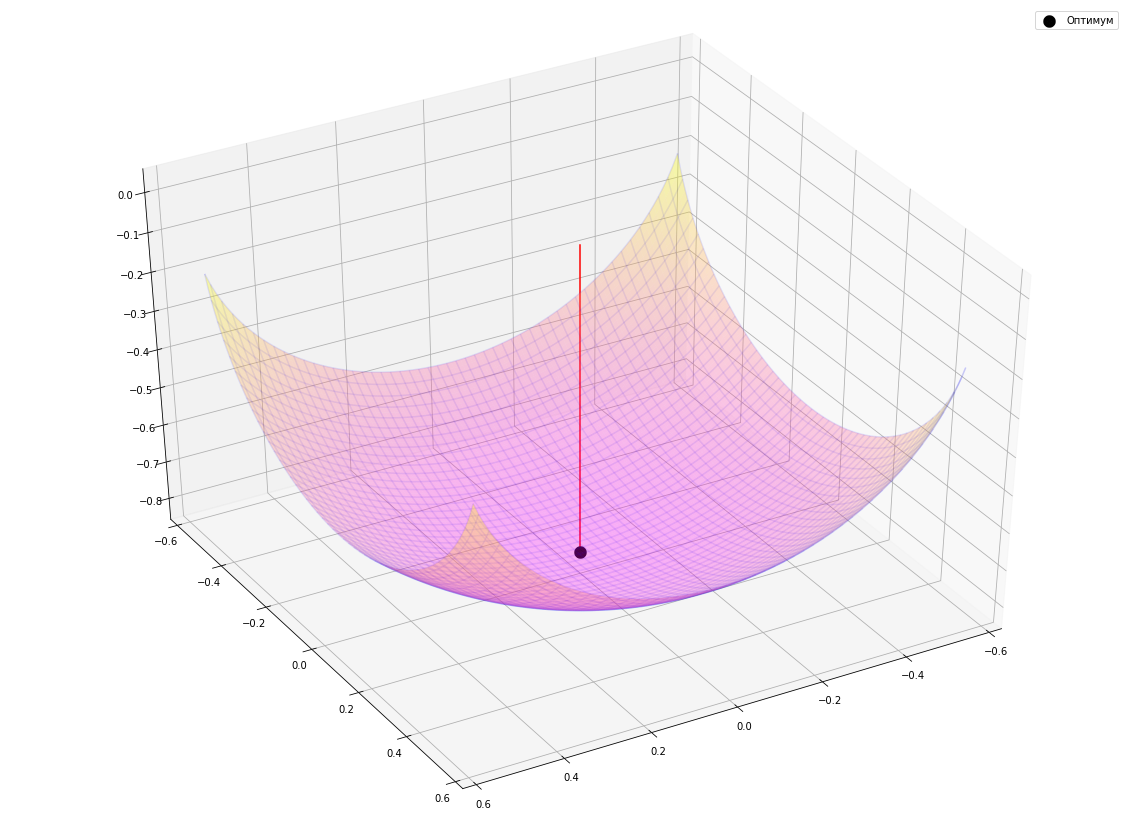

In [ ]:
Vsgd = SGD(f = Function.SPHERE)
Vsgd.Plot_Function(a = 60, difference=0.55, opt = -0.8)

###Визуализация функции Матьяса

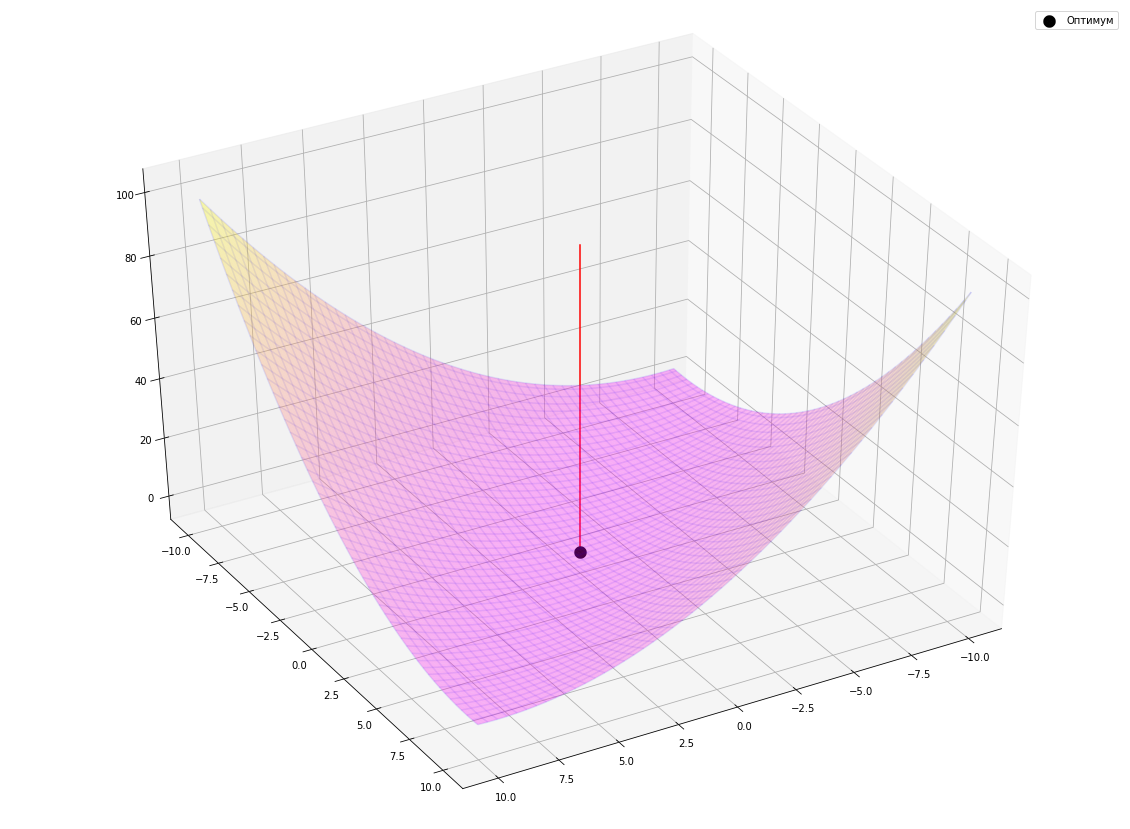

In [ ]:
Vsgd = SGD()
Vsgd.Plot_Function(a = 60)

In [ ]:
sgd.Plot_Plot(m_q1_m, m_q2_m, m_q3_m, difference=0.5, a=0, h = 40)

##1.3 SGD

###1.3.1 Демонстрация работы SGD для функции сферы
####Визуализация работы SGD для функции сферы

Оптимум в точке:
[x, y, z] = 0, 0, -0.8
Реузльтат работы SGD: 
[~x, ~y, ~z] =  -0.017925637357739003 ,  -0.017925637357739003 ,  -0.7995982385239713


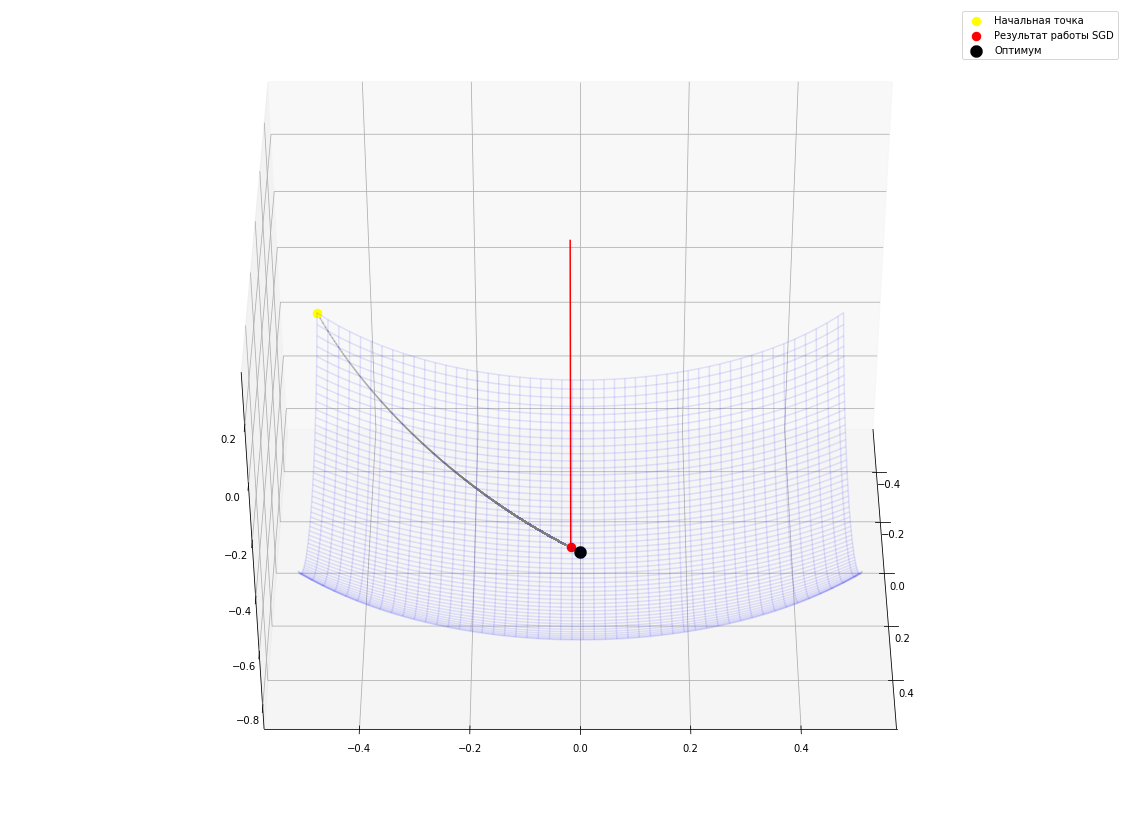

In [21]:
sgd = SGD(f=Function.SPHERE,  lr = 0.005, size_batch = 100, count_epochs = 1000, size_dataset = 10000, x0= -0.5, y0 = -0.5)
sgd.Set_Train_Plot(difference=0.001)
s_q1, s_q2, s_q3 = sgd.SGD_Plot()
print("Оптимум в точке:")
print("[x, y, z] = 0, 0, -0.8")
sgd.Print_Answer_SGD_Plot(s_q1, s_q2, s_q3)
_History_s_simple  = sgd.Get_History()
sgd.Plot_Plot(s_q1, s_q2, s_q3, difference=0.5, a=0, h = 40)

###1.3.2 Демонстрация работы SGD для функции Матьяса
####Визуализация работы SGD для функции Матьяса

Оптимум в точке:
[x, y, z] = 0, 0, 0
Реузльтат работы SGD: 
[~x, ~y, ~z] =  -0.09350164662134652 ,  -0.09350164662134652 ,  0.000349702316836128


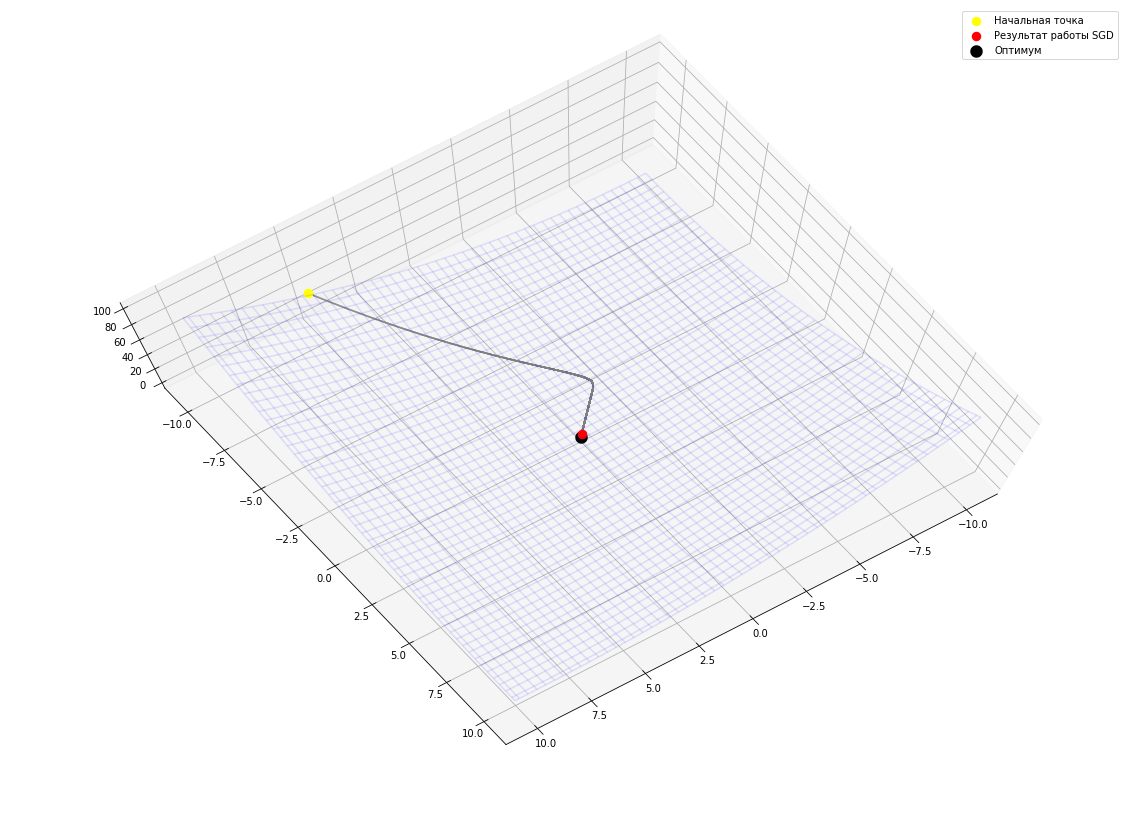

In [22]:
sgd = SGD(lr = 0.001, size_batch = 20, count_epochs = 100, size_dataset = 10000, x0= 5.1, y0 = -10.101)
sgd.Set_Train_Plot(difference=1)
m_q1, m_q2, m_q3 = sgd.SGD_Plot()
print("Оптимум в точке:")
print("[x, y, z] = 0, 0, 0")
sgd.Print_Answer_SGD_Plot(m_q1, m_q2, m_q3)
_History_m_simple  = sgd.Get_History()
sgd.Plot_Plot(m_q1, m_q2, m_q3, difference=10)

##1.4 SGD с моментной модификацией и адаптивной

###1.4.1 Демонстрация работы SGD с моментоной модификацией для функции сферы
####Визуализация работы SGD c моментной модификацией для функции сферы

Оптимум в точке:
[x, y, z] = 0, 0, -0.8
Реузльтат работы SGD: 
[~x, ~y, ~z] =  -2.5e-323 ,  -2.5e-323 ,  -0.8


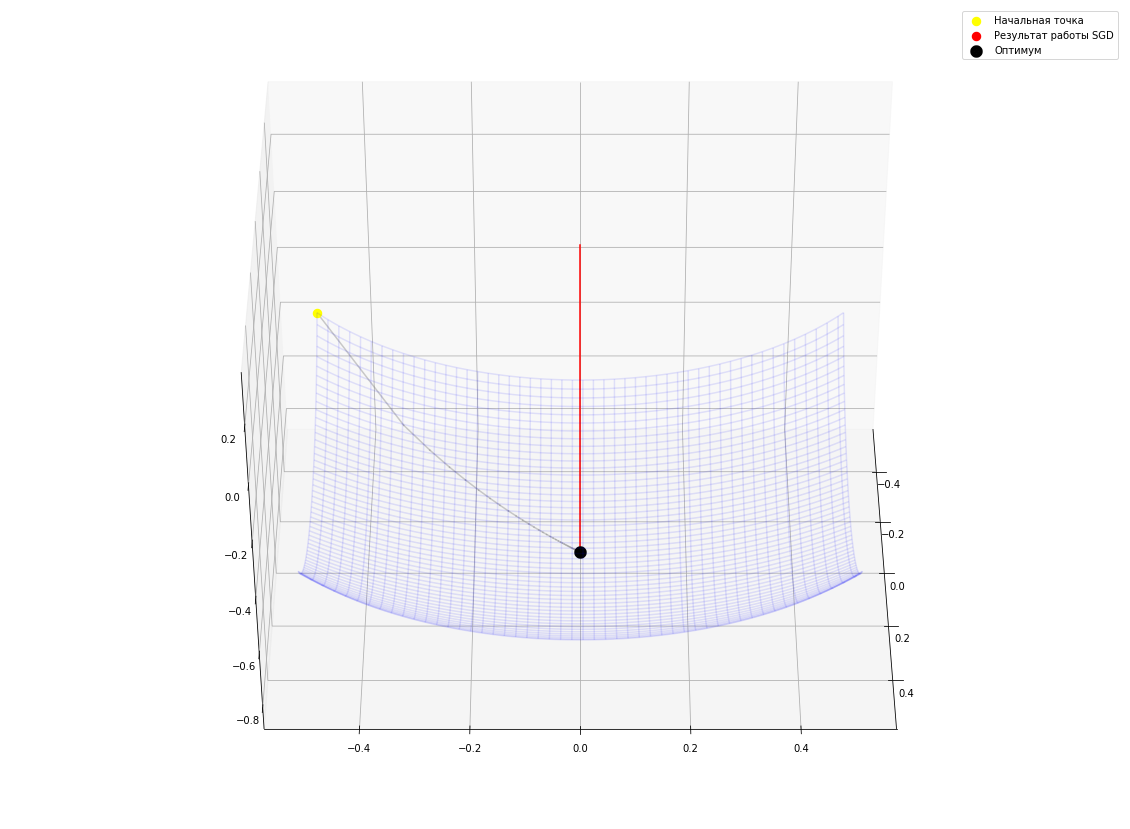

In [23]:
sgd = SGD(f=Function.SPHERE, mod = SGD_Modification.MOMENT, lr = 0.005, size_batch = 100, count_epochs = 1000, size_dataset = 10000, x0= -0.5, y0 = -0.5)
sgd.Set_Train_Plot(difference=0.001)
s_q1_m, s_q2_m, s_q3_m = sgd.SGD_Plot()
print("Оптимум в точке:")
print("[x, y, z] = 0, 0, -0.8")
sgd.Print_Answer_SGD_Plot(s_q1_m, s_q2_m, s_q3_m)
_History_s_moment  = sgd.Get_History()
sgd.Plot_Plot(s_q1_m, s_q2_m, s_q3_m, difference=0.5, a=0, h = 40)

###1.4.2 Демонстрация работы SGD с моментоной модификацией для функции Матьяса
####Визуализация работы SGD c моментной модификацией для функции Матьяса

Оптимум в точке:
[x, y, z] = 0, 0, 0
Реузльтат работы SGD: 
[~x, ~y, ~z] =  -2.5e-323 ,  -2.5e-323 ,  0.0


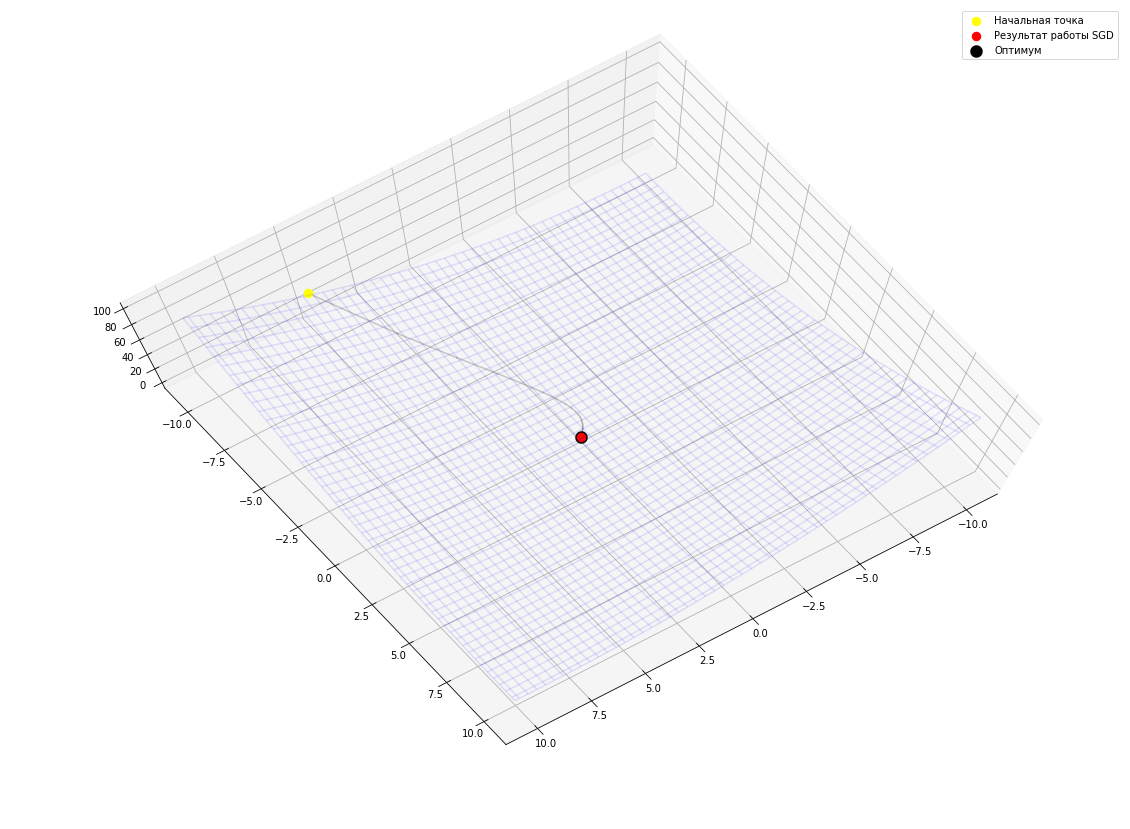

In [25]:
sgd = SGD(f=Function.MATIAS, mod = SGD_Modification.MOMENT, lr = 0.001, size_batch = 20, count_epochs = 100, size_dataset = 10000, x0= 5.1, y0 = -10.101)
sgd.Set_Train_Plot(difference=0.001)
m_q1_m, m_q2_m, m_q3_m = sgd.SGD_Plot()
print("Оптимум в точке:")
print("[x, y, z] = 0, 0, 0")
sgd.Print_Answer_SGD_Plot(m_q1_m, m_q2_m, m_q3_m)
_History_m_moment  = sgd.Get_History()
sgd.Plot_Plot(m_q1_m, m_q2_m, m_q3_m, difference=10)

###1.4.3 Демонстрация работы SGD с адаптивной модификацией для функции Сферы
####Визуализация работы SGD c адаптивной модификацией для функции Сферы

Оптимум в точке:
[x, y, z] = 0, 0, -0.8
Реузльтат работы SGD: 
[~x, ~y, ~z] =  2.2055e-320 ,  -0.0081091047156039 ,  -0.799958900457212


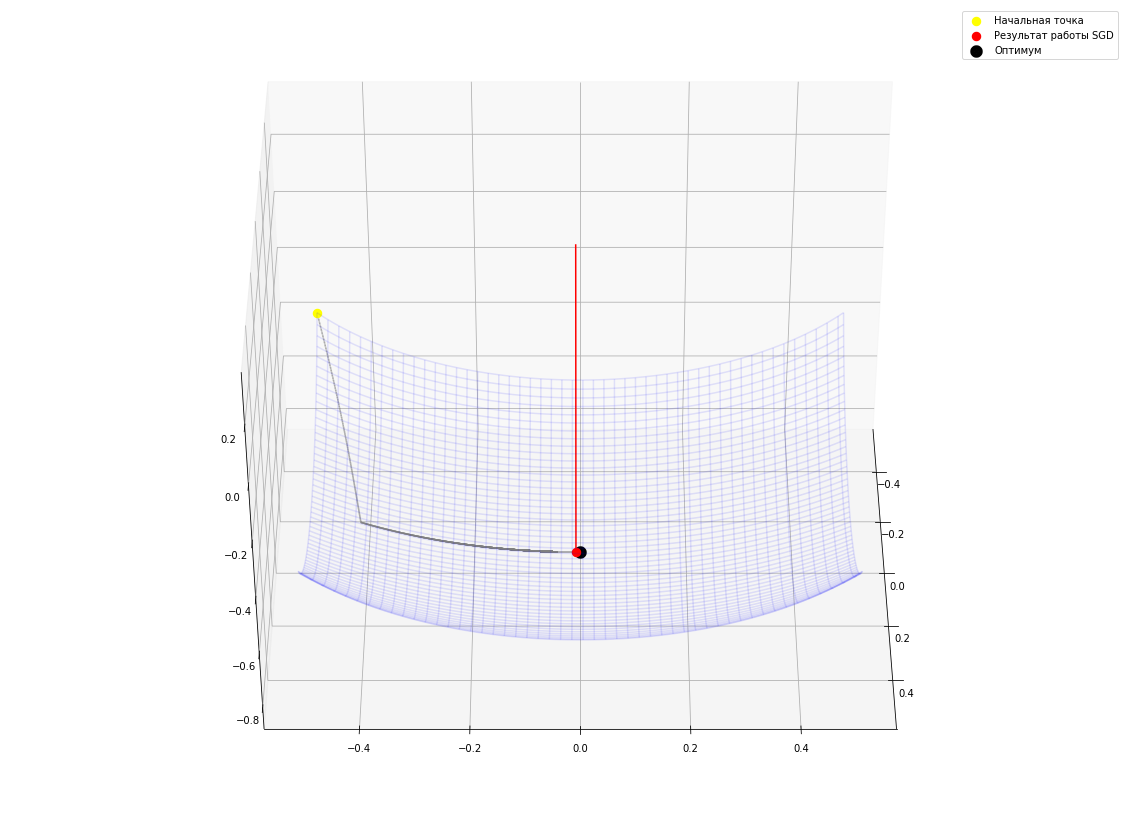

In [28]:
sgd = SGD(f=Function.SPHERE, mod = SGD_Modification.ADAPTIVE, lr = 0.005, size_batch = 100, count_epochs = 1000, size_dataset = 10000, x0= -0.5, y0 = -0.5)
sgd.Set_Train_Plot(difference=0.001)
s_q1_a, s_q2_a, s_q3_a = sgd.SGD_Plot()
print("Оптимум в точке:")
print("[x, y, z] = 0, 0, -0.8")
sgd.Print_Answer_SGD_Plot(s_q1_a, s_q2_a, s_q3_a)
_History_s_adaptive  = sgd.Get_History()
sgd.Plot_Plot(s_q1_a, s_q2_a, s_q3_a, difference=0.5, a=0, h = 40)

###1.4.4 Демонстрация работы SGD с адаптивной модификацией для функции Матьяса
####Визуализация работы SGD c адаптивной модификацией для функции Матьяса

Оптимум в точке:
[x, y, z] = 0, 0, 0
Реузльтат работы SGD: 
[~x, ~y, ~z] =  -1.728529310727157e-11 ,  -1.8698267786428893e-11 ,  1.3447290906891416e-23


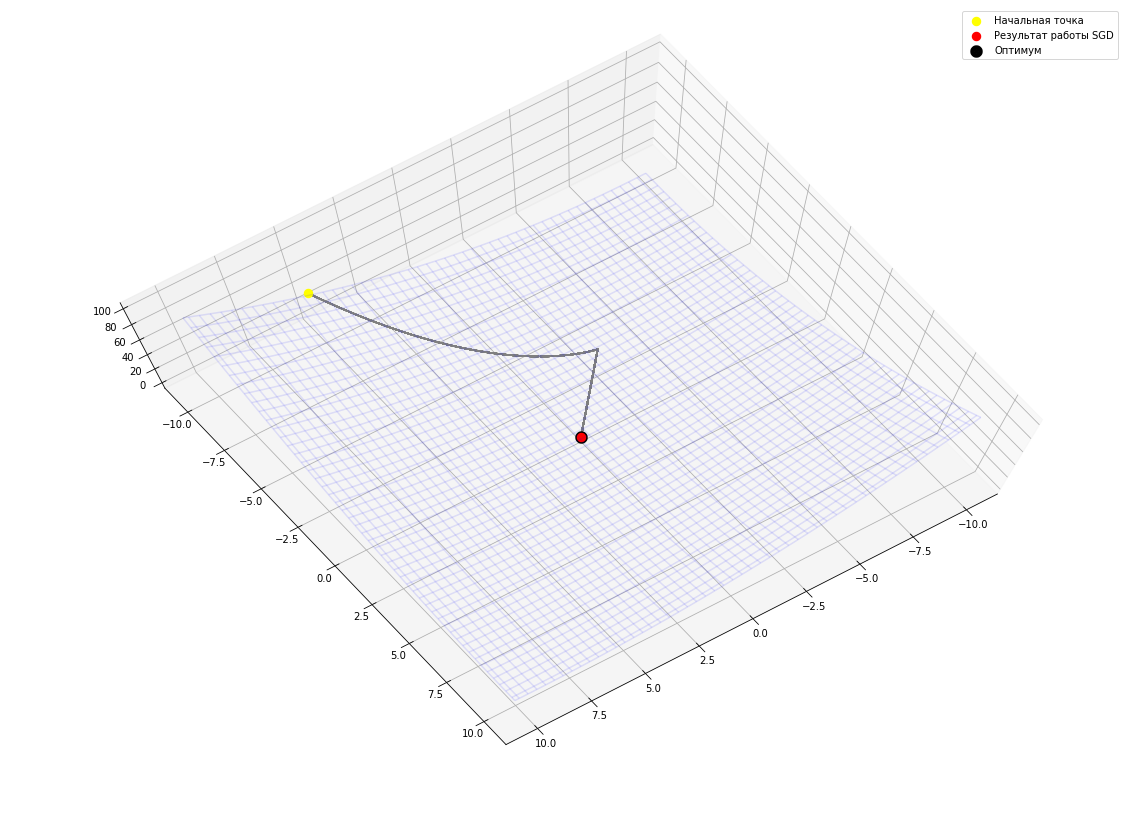

In [29]:
sgd = SGD(f=Function.MATIAS, mod = SGD_Modification.ADAPTIVE, lr = 0.001, size_batch = 20, count_epochs = 100, size_dataset = 10000, x0= 5.1, y0 = -10.101)
sgd.Set_Train_Plot(difference=0.001)
m_q1_a, m_q2_a, m_q3_a = sgd.SGD_Plot()
print("Оптимум в точке:")
print("[x, y, z] = 0, 0, 0")
sgd.Print_Answer_SGD_Plot(m_q1_a, m_q2_a, m_q3_a)
_History_m_adaptive  = sgd.Get_History()
sgd.Plot_Plot(m_q1_a, m_q2_a, m_q3_a, difference=10)

## 1.5 Анимация SGD, SGD с моментной и адаптивной модификациями

In [116]:
animationSGD = AnimationSGD(_History_s_simple, _History_s_moment, _History_s_adaptive, f = Function.SPHERE)
animationSGD.Start_Animation()

#2. Датасет

##Демонстрация работы SGD для задачи линейной регрессии
###Визуализация прямой, наилучим оборазом соответсвующая сгенерированным точкам 

In [ ]:
dSgd = SGD(lr = 0.01, size_batch = 5, count_epochs = 1000, size_dataset = 50)
dSgd.Set_Train_Dataset()
a, b, c = dSgd.SGD_Dataset()
dSgd.Print_Train_SGD_Dataset()
dSgd.Print_Answer_SGD_Dataset(a, b, c)

Искомая прямая: 
x =  1.4938585901766233 t
y =  0.3469570268842122 t
z =  0.44744367706627625 t
Реузльтат работы SGD: 
~x =  1.4945226426410367 t
~y =  0.3468222459081913 t
~z =  0.4475557009194949 t


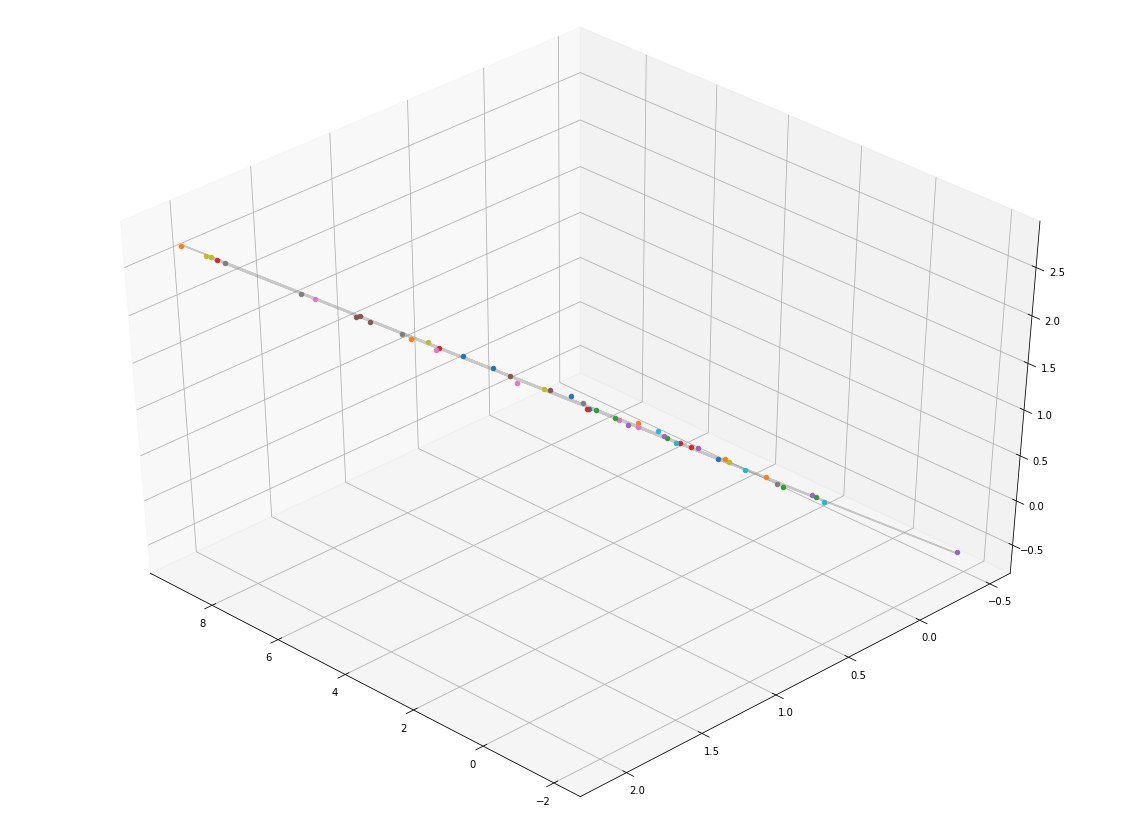

In [ ]:
dSgd.Plot_Dataset(a, b, c, an = 135)